### Build the pure text

In [3]:
import json

input_file = 'devtwitter.json'
output_file = 'devtwitter-pure-text.txt'

def extract_text(message):
    """Extract and flatten text content."""
    text = message.get('text')
    if isinstance(text, str):
        return text.strip()
    elif isinstance(text, list):
        return ''.join(
            part['text'] if isinstance(part, dict) else part
            for part in text
        ).strip()
    return ''

with open(input_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

all_lines = []
for item in data.get('messages'):
    if item.get('type') == 'message':
        pure_text = extract_text(item)
        if pure_text:
            all_lines.append(pure_text)

with open(output_file, 'w', encoding='utf-8') as f:
    for line in all_lines:
        f.write(line + '\n')

print(f'✅ Text file saved in {output_file}')


✅ Text file saved in devtwitter-pure-text.txt


### Word Clouds

#### General Word Cloud

In [ ]:
!pip install wordcloud matplotlib hazm

In [ ]:
!pip install arabic-reshaper python-bidi

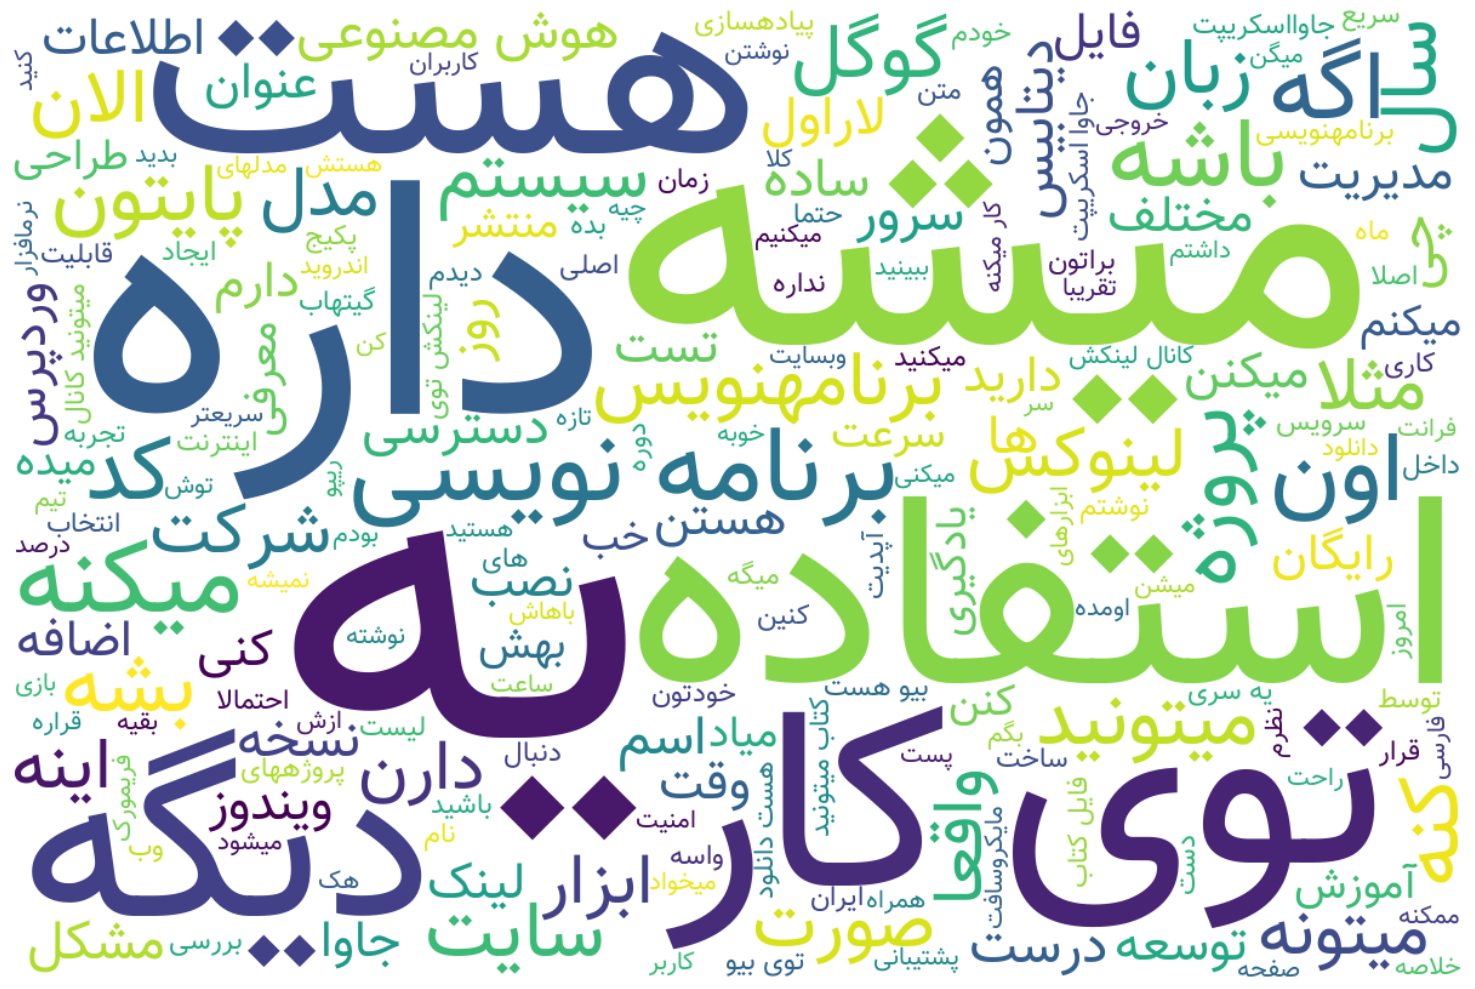

✅ WordCloud saved to: devtwitter-wordcloud.png


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from hazm import Normalizer, stopwords_list
import arabic_reshaper
from bidi.algorithm import get_display
import re

# File paths
input_file = 'devtwitter-pure-text.txt'
output_image = 'images/devtwitter-general-wordcloud.png'

# Load and normalize text
with open(input_file, 'r', encoding='utf-8') as f:
    text = f.read()

normalizer = Normalizer()
text = normalizer.normalize(text)
text = re.sub(r'[^\u0600-\u06FF\s]', '', text)  # remove non-Persian chars

# Remove stopwords
stopwords = set(stopwords_list())
words = [word for word in text.split() if word not in stopwords and len(word) > 1]
clean_text = ' '.join(words)

# Reshape and fix RTL display
reshaped_text = arabic_reshaper.reshape(clean_text)         # reshape letters
bidi_text = get_display(reshaped_text)                      # fix RTL direction

# Generate WordCloud
wordcloud = WordCloud(
    font_path='assets/Vazir-Regular.ttf',
    background_color='white',
    width=1200,
    height=800
).generate(bidi_text)

# Show and save
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig(output_image, dpi=300)
plt.show()

print(f'✅ WordCloud saved to: {output_image}')


#### Names Word Cloud

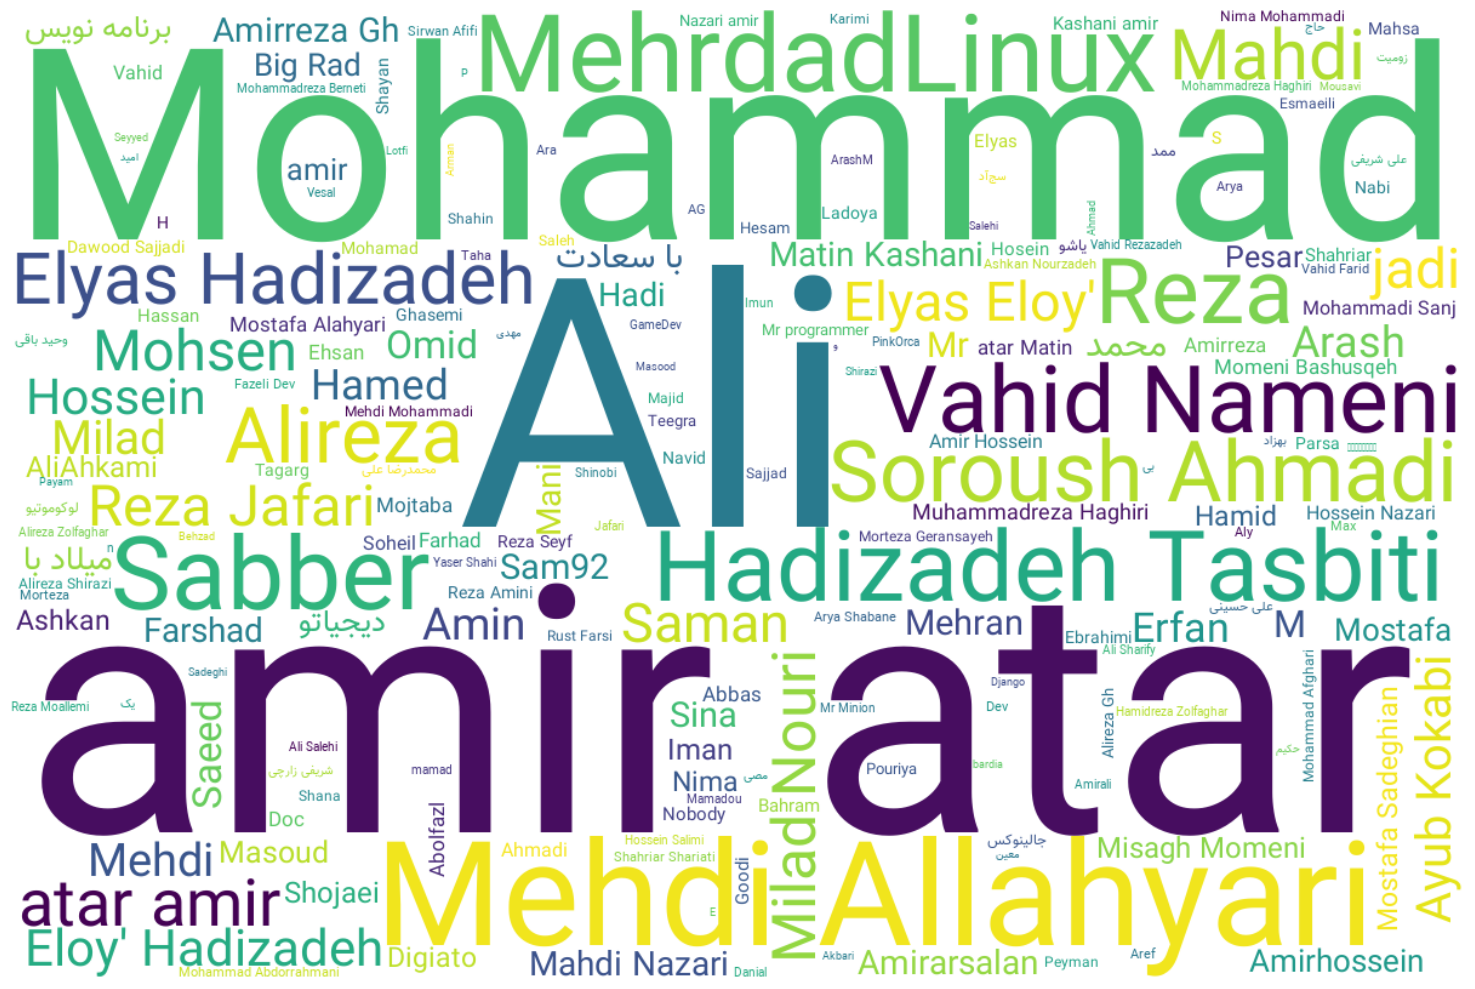

✅ WordCloud of name tags saved to: images/name-tags-wordcloud.png


In [ ]:
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# Settings
input_file = 'devtwitter-pure-text.txt'
output_image = 'images/name-tags-wordcloud.png'

# Read text file
with open(input_file, 'r', encoding='utf-8') as f:
    text = f.read()

# Match <Name Surname/> pattern
name_tags = re.findall(r'<([^<>\/]+?)\s*\/>', text)

# Join all names into one string (space-separated for WordCloud)
joined_names = ' '.join(name_tags)

# Optional: if some names are Persian, reshape + bidi them
reshaped_text = arabic_reshaper.reshape(joined_names)
bidi_text = get_display(reshaped_text)

# Generate WordCloud
wordcloud = WordCloud(
    font_path='assets/Vazir-Regular.ttf',
    background_color='white',
    width=1200,
    height=800
).generate(bidi_text)

# Display and save
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig(output_image, dpi=300)
plt.show()

print(f'✅ WordCloud of name tags saved to: {output_image}')


### Time-based Trends + Animated Bar Chart Race

In [ ]:
!pip install pandas matplotlib hazm arabic-reshaper python-bidi bar_chart_race

In [ ]:
custom_stopwords = {
    'یه', 'توی', 'همین', 'و', 'ها', 'شده', 'شون', 'اینا', 'اون', 'این', 'ما', 'تو',
    'من', 'کرده', 'کردن', 'است', 'هست', 'نیست', 'داره', 'داشت', 'دارن', 'بود', 'باید',
    'الان', 'هم', 'همه', 'با', 'بی', 'برای', 'به', 'از', 'که', 'ولی', 'اگه', 'اگر',
    'می', 'نه', 'اما', 'همین', 'چون', 'بعد', 'تا', 'هر', 'خود', 'شما', 'شاید', 'یک',
    'میکنه','میشه', 'استفاده', 'دیگه', 'باشه', 'کنه', 'بشه', 'میکنم', 'می کنم', 'میده', 'میتونید', 
}

# Programming languages (English + Persian forms)
programming_keywords = {
    'python', 'پایتون',
    'javascript', 'جاوااسکریپت', 'js',
    'typescript', 'تایپ‌اسکریپت',
    'java', 'جاوا',
    'c', 'سی',
    'c++', 'سی پلاس پلاس',
    'c#', 'سی شارپ',
    'php', 'پی‌اچ‌پی',
    'go', 'گولنگ', 'گو',
    'ruby', 'روبی',
    'swift', 'سوئیفت',
    'kotlin', 'کاتلین',
    'dart', 'دارت',
    'rust', 'راست',
    'scala', 'اسکالا',
    'r', 'آر',
    'shell', 'شِل', 'بَش', 'بش',
    'sql', 'اس‌کیو‌ال', 'اس کیو ال',
    'html', 'اچ‌تی‌ام‌ال',
    'css', 'سی‌اس‌اس',
    'assembly', 'اسمبلی',
    'matlab', 'متلب',
    'fortran', 'فورترن',
    'perl', 'پرل',
    'lua', 'لوا'
}

#### General Timeline

In [ ]:
import json
import pandas as pd
from hazm import Normalizer, stopwords_list
import re
from collections import Counter
from datetime import datetime
import arabic_reshaper
from bidi.algorithm import get_display
import bar_chart_race as bcr

with open('devtwitter.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

normalizer = Normalizer()

stopwords = set(stopwords_list())
stopwords = stopwords.union(custom_stopwords)
monthly_word_counts = {}

for msg in data.get('messages', []):
    if msg.get('type') != 'message' or 'text' not in msg:
        continue

    text = msg['text']
    if isinstance(text, list):
        text = ''.join(part['text'] if isinstance(part, dict) else part for part in text)
    if not isinstance(text, str):
        continue

    date_str = msg.get('date')
    if not date_str:
        continue
    dt = datetime.fromisoformat(date_str)
    month = datetime(dt.year, dt.month, 1)

    text = normalizer.normalize(text)
    words = [w for w in text.split() if w not in stopwords and len(w) > 1]

    if month not in monthly_word_counts:
        monthly_word_counts[month] = Counter()
    monthly_word_counts[month].update(words)

months_sorted = sorted(monthly_word_counts.keys())
all_words = set()
for counter in monthly_word_counts.values():
    all_words.update(counter.keys())

months_sorted = pd.to_datetime(months_sorted)

df = pd.DataFrame(index=months_sorted, columns=list(all_words)).fillna(0)

for month in months_sorted:
    for word, count in monthly_word_counts[month].items():
        df.at[month, word] = count

top_words = df.sum().sort_values(ascending=False).head(20).index
df = df[top_words]

df.columns = [
    get_display(arabic_reshaper.reshape(col))
    for col in df.columns
]

bcr.bar_chart_race(
    df=df,
    filename='images/word_trends.mp4',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=50,
    period_length=3000,
    period_fmt='%B %Y',
    title='🔥 Trending Persian Words Over Time',
    bar_size=.95,
    cmap='dark12',
    filter_column_colors=True
)

print("✅ Word trend video saved as: images/word_trends.mp4")


#### Programming Languages Timeline

In [ ]:
import json
import pandas as pd
from hazm import Normalizer
import re
from collections import Counter
from datetime import datetime
import arabic_reshaper
from bidi.algorithm import get_display
import bar_chart_race as bcr

with open('devtwitter.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

normalizer = Normalizer()
monthly_word_counts = {}


programming_keywords = set([normalizer.normalize(w.lower()) for w in programming_keywords])

for msg in data.get('messages', []):
    if msg.get('type') != 'message' or 'text' not in msg:
        continue

    text = msg['text']
    if isinstance(text, list):
        text = ''.join(part['text'] if isinstance(part, dict) else part for part in text)
    if not isinstance(text, str):
        continue

    date_str = msg.get('date')
    if not date_str:
        continue
    dt = datetime.fromisoformat(date_str)
    month = datetime(dt.year, dt.month, 1)

    text = normalizer.normalize(text)
    text = re.sub(r'[^\u0600-\u06FFa-zA-Z+#\s]', '', text)
    words = [w.lower() for w in text.split() if w.lower() in programming_keywords]

    if not words:
        continue

    if month not in monthly_word_counts:
        monthly_word_counts[month] = Counter()
    monthly_word_counts[month].update(words)

months_sorted = sorted(monthly_word_counts.keys())
all_words = set()
for counter in monthly_word_counts.values():
    all_words.update(counter.keys())

months_sorted = pd.to_datetime(months_sorted)
df = pd.DataFrame(index=months_sorted, columns=list(all_words)).fillna(0)

for month in months_sorted:
    for word, count in monthly_word_counts[month].items():
        df.at[month, word] = count

top_words = df.sum().sort_values(ascending=False).head(20).index
df = df[top_words]

df.columns = [
    get_display(arabic_reshaper.reshape(col))
    for col in df.columns
]

bcr.bar_chart_race(
    df=df,
    filename='images/programming_lang_trends.mp4',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=50,
    period_length=3000,
    period_fmt='%B %Y',
    title='📊 Trending Programming Languages in DevTwitter Channel',
    bar_size=.95,
    cmap='dark12',
    filter_column_colors=True
)

print("✅ Programming language trend video saved as: images/programming_lang_trends.mp4")

: 